# Baseline multilayer perceptron experiment
In this notebook we implement a baseline neural network with one hidden layer, _raw audio samples_ as an input and one _note probability vector_ as an output. After one epoch, the model reaches 30% accuracy on the test set. Accuracy on the train set is very low (23%) which suggests that the model capacity is too low.

Metric | Result
--- | ---
Precision | 61.51%
Recall | 37.30%
Accuracy | 30.24%

By inspection of the annotated excerpts (see the _Evaluation_ section) we see that the network doesn't work reliably even on solo, monophonic cello recording, which should be in theory the easiest to transcribe of the four parts of the `small_test_dataset`. (Existing monopitch trackers achieve accuracies over 95% [1]) This is expected since the multilayer perceptron is such a simple ML model.

[1] M. Mauch and S. Dixon, “pYIN: A Fundamental Frequency Estimator Using Probabilistic Threshold Distributions,” in Proceedings of the IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP 2014), 2014.

## Training

In [1]:
# for automatic reloading of my libraries
%load_ext autoreload
%autoreload 2

In [ ]:
import tensorflow as tf
import numpy as np

import datasets
from model import Network

import visualization as vis

import datetime

In [3]:
MUSICNET_ROOT = "/home/jirka/bakalarka/melody_extraction/datasets/musicnet"
test_data = datasets.musicnet_dataset(MUSICNET_ROOT, "test")
train_data = datasets.musicnet_dataset(MUSICNET_ROOT, "train")

.......... OK
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
 OK


In [4]:
annotations_per_window = 1
context_width = 944

test_dataset = datasets.AADataset(test_data, annotations_per_window, context_width, shuffle_batches=False)
train_dataset = datasets.AADataset(train_data, annotations_per_window, context_width, shuffle_batches=True)

In [5]:
# small dataset for manual evaluation
small_test_data = [
    test_data[3].slice(15,20.8), # solo cello
    test_data[9].slice(56,61.4), # solo piano
    test_data[5].slice(55.6,61.6), # orchestra
    test_data[2].slice(17.65,27), # violin + string section
]
small_test_dataset = datasets.AADataset(small_test_data, annotations_per_window, context_width, shuffle_batches=False)

In [6]:
def create_model(self, args):
    # Perceptron baseline
    audio_net = tf.layers.dense(self.window, 1000, activation=tf.nn.relu)
    output_layer = tf.layers.dense(audio_net, self.note_range*self.annotations_per_window, activation=None, name="output")
    ref_notes_flat = tf.layers.flatten(self.ref_notes)

    self.note_probabilites = tf.reshape(output_layer, [-1, self.annotations_per_window, self.note_range])
    self.est_notes = tf.cast(tf.greater(self.note_probabilites, 0.5), tf.float32)
    
    self.loss = tf.losses.sigmoid_cross_entropy(ref_notes_flat, output_layer)

    global_step = tf.train.create_global_step()
    self.training = tf.train.AdamOptimizer().minimize(self.loss, global_step=global_step)

In [7]:
restore = None

# Create logdir name
args = {
    "threads": 6,
    "batch_size": 64,
    "logdir": None,
    "annotations_per_window": test_dataset.annotations_per_window,
    "window_size": test_dataset.window_size,
    "note_range": 96,
    "samplerate": test_dataset.samplerate
}
name = "{}-bs{}-apw{}-wsiz{}".format(
    datetime.datetime.now().strftime("%m-%d_%H%M%S"),
    args["batch_size"],
    args["annotations_per_window"],
    args["window_size"],
)

if restore:
    name = restore
args["logdir"] = "models/" + name

print(name)

# Construct the network
network = Network(threads=args["threads"])
network.construct(args, create_model)

if restore:
    network.restore()

06-25_014435-bs64-apw1-wsiz2048


In [8]:
epochs = 1
network.train(train_dataset, test_dataset, small_test_dataset, args["batch_size"], epochs, eval_every_n_batches=10000, save_every_n_batches=20000)

=== epoch 1 ===
.....b 1000; t 2.89; acc 0.04; loss 0.10
.....b 2000; t 2.41; acc 0.12; loss 0.11
.....b 3000; t 2.41; acc 0.11; loss 0.11
.....b 4000; t 2.40; acc 0.13; loss 0.10
.....b 5000; t 2.42; acc 0.09; loss 0.09
.....b 6000; t 2.41; acc 0.13; loss 0.09
.....b 7000; t 2.41; acc 0.15; loss 0.10
.....b 8000; t 2.28; acc 0.12; loss 0.10
.....b 9000; t 2.14; acc 0.15; loss 0.09
.....b 10000; t 2.15; acc 0.17; loss 0.10
epoch 1, batch 10000, t 27.44, accuracy: 0.19
.....b 11000; t 2.15; acc 0.13; loss 0.10
.....b 12000; t 2.14; acc 0.15; loss 0.10
.....b 13000; t 2.13; acc 0.12; loss 0.09
.....b 14000; t 2.13; acc 0.13; loss 0.10
.....b 15000; t 2.13; acc 0.19; loss 0.10
.....b 16000; t 2.13; acc 0.17; loss 0.10
.....b 17000; t 2.13; acc 0.14; loss 0.09
.....b 18000; t 2.12; acc 0.13; loss 0.10
.....b 19000; t 2.13; acc 0.12; loss 0.10
.....b 20000; t 2.13; acc 0.19; loss 0.09
epoch 1, batch 20000, t 28.02, accuracy: 0.23
Model saved in path: models/06-25_014435-bs64-apw1-wsiz2048/m

In [ ]:
network.save()

## Evaluation

Model saved in path: models/06-25_014435-bs64-apw1-wsiz2048/model.ckpt
Testing dataset metrics:
Precision 0.6150502390557299
Recall 0.37302942517408455
Accuracy 0.3024220579457275
Substitution Error 0.12899955540830224
Miss Error 0.4979710194176132
False Alarm Error 0.1044733853817117
Total Error 0.7314439602076271
Chroma Precision 0.6742538846556103
Chroma Recall 0.40893657630411206
Chroma Accuracy 0.3414731615039016
Chroma Substitution Error 0.09309240427827475
Chroma Miss Error 0.4979710194176132
Chroma False Alarm Error 0.1044733853817117
Chroma Total Error 0.6955368090775996

Small testing dataset metrics:
Precision 0.5900314324202963
Recall 0.38686883556602386
Accuracy 0.30490776192133656
Substitution Error 0.13616958633887827
Miss Error 0.47696157809509787
False Alarm Error 0.1326365376122479
Total Error 0.745767702046224
Chroma Precision 0.6600808262236192
Chroma Recall 0.43279846901221847
Chroma Accuracy 0.3539183820873962
Chroma Substitution Error 0.09023995289268365
Chroma M

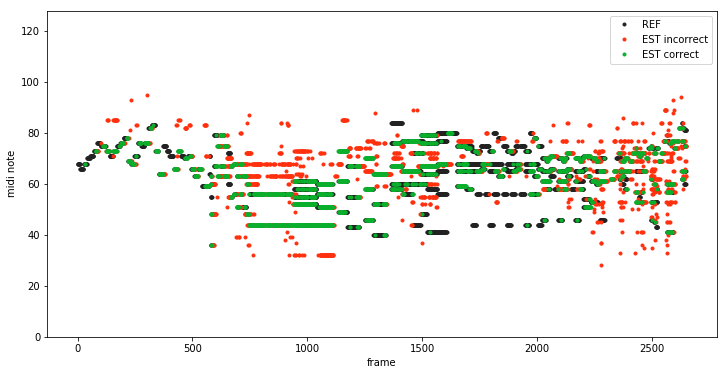

In [9]:
print("Testing dataset metrics:")
acc = network.evaluate(test_dataset, args["batch_size"], print_detailed=True)
print("\nSmall testing dataset metrics:")
acc = network.evaluate(small_test_dataset, args["batch_size"], visual_output=True, print_detailed=True)

In [10]:
# play the small testing dataset
vis.samplesplayer(small_test_dataset.all_samples(), small_test_dataset.samplerate)